## Cálculo das curvas de referência e curvas SPR para diversos analitos

Importação das bibliotecas necessárias:

In [1]:
from scipy.integrate import *
from random import gauss, uniform
import sympy as smp
from numpy import *
import Reflectivity as ref
import Setting_Layers as sl
import matplotlib.pyplot as plt
import pandas as pd
import time

Importação de arquivos dos experimentos:

In [68]:
dados = pd.read_csv("experimento_H2O.csv", encoding='latin1')
dados2 = pd.read_csv("experimento_H2O_2.csv", encoding='latin1')
dados3 = pd.read_csv("experimento_H2O_1.csv", encoding='latin1')
dados4 = pd.read_csv("signal reference.csv", encoding='latin1')

pixel = dados['pixel']
#pixel = pixel[::-1]
signal_ref = dados4['Reference']


#signal = dados[' signal']*signal_ref
signal = dados[' signal']
signal2 = dados2['Chan 1']
signal3 = dados3['Chan 1']/signal_ref

mn = min(signal_ref)
mx = max(signal_ref)

noise_ref = []
noise_term = []

theta_i = []

for i in pixel:
    theta_i.append((3.1522 * 1E-5 * i**2) - (0.0661 * i) + 73.4533)
    a, b = uniform(mn,mx), gauss(mean(0), 0.05)
    noise_ref.append(a)
    noise_term.append(b)

# Declaração da função gaussiana que modela o espalhamento do Led
dc = 0.785
a = 1/(sqrt(2*pi))

p = lambda w_i: (dc + (a/2.7)* exp(-(((w_i - 845)/30)**2))) * (dc + (a/2.7)* exp(-(((w_i - 853)/15)**2))) * (1.01 + (a/3)* exp(-(((w_i - 845)/42)**2)))

# Definição de função para calcular o indice de refração
def set_index_3(lambda_i, material):
    
    ref_index = (sl.set_index(material, lambda_i*1E-9))

    return ref_index

idx = lambda w_i, material: set_index_3(w_i, material)

### Inicio do cálculo para a curva de referência

Definição da função que calcula a reflectância

In [69]:

r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], [idx(lambda_i, 21), idx(lambda_i, 13), idx(lambda_i,17)], theta*pi/180, lambda_i*1e-9)
    

Definição da função f($\lambda$,$\theta$) = r($\lambda$, $\theta$) $\cdot$ $\rho$ ($\lambda$) que modela a ponderação do espalhamento do LED em cada comprimento de onda.

In [70]:
def f(w_i, theta):
    return (r(theta, w_i)*p(w_i))

Definição da integral $\int_{\lambda_I}^{\lambda_F} r(\lambda, \theta)* p(\lambda)\,d\lambda$

In [71]:
integrals = [[a, quad(f,  745, 935, args=(a))[0]] for a in linspace(73.6872,65.80896, 128)]

/tmp/ipykernel_19906/1574118220.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrals = [[a, quad(f,  745, 935, args=(a))[0]] for a in linspace(73.6872,65.80896, 128)]


Resolução da equação: $R(\theta)$ = $\frac{\int_{\lambda_I}^{\lambda_F} r(\lambda, \theta)* p(\lambda)\,d\lambda}{\rho(\lambda)}$
e normalização de $R(\theta)$ pelo seu valor máximo

In [72]:
reflectancia= array(integrals).T[1] / quad(p, 745, 935)[0]

reflectancia_norm = reflectancia/max(reflectancia)


Incremento do ruído térmico no sinal de tensão resultado de 'reflectancia_norm*noise_ref'

In [73]:
reflectancia_norm = (reflectancia_norm * noise_ref)+ noise_term

Criação do arquivo para salvar os dados da curva de referência

In [74]:
arquivo = open('Reference_data.csv','w')
arquivo.write("Pixel #,Angle,Signal")
for i in range(len(theta_i)):
    arquivo.write(f"\n{pixel[i]},{theta_i[i]},{reflectancia_norm[i]}")
arquivo.close()

Plotagem do sinal de referência para verificação

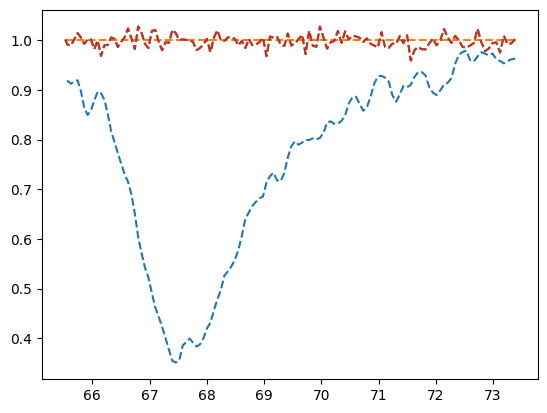

In [75]:
signal_ref_txt = pd.read_csv('Reference_data.csv', encoding='latin1')

pixel_ = signal_ref_txt['Pixel #']
angle_ = signal_ref_txt['Angle']
signal_ = signal_ref_txt['Signal']

plt.plot(theta_i, signal, '--', label= 'Signal Exp 1')
plt.plot(theta_i, signal_ref/signal_ref, '--', label= 'Signal Exp Ref')
plt.plot(angle_, (signal_/noise_ref),'--', label= 'Signal Ref TXT' )
plt.plot(theta_i, reflectancia_norm/noise_ref, '--', label= 'Signal Simulated')



### A partir daqui será o calculo das curvas para um analido com IR > 1.32 RIU

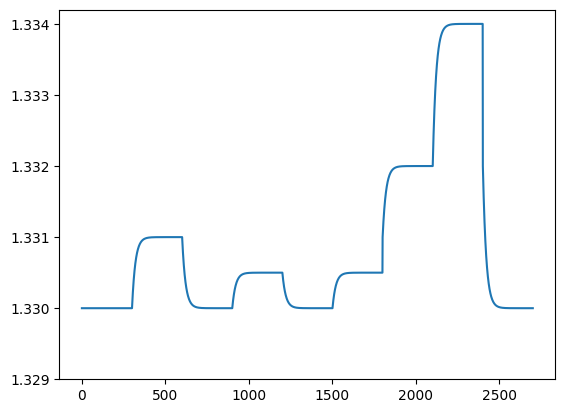

In [76]:
Idc = float(1.33000)

tau = 20

idcs = [0.0010, 0.0010, 0.0005, 0.0005, 0.0005, 0.001, 0.002, 0.002]

carga = [True, False, True, False, True, True, True, False]
count = 0
ri = []
while (count < 300):
    ri.append(1.33)
    count+=1
count = 0

for dc in range(len(carga)):
    if carga[dc]:
        while (count < 300):
            if carga[dc-1]==False:
                v = Idc + idcs[dc]*(1 - exp(-count/tau))
                ri.append(v)
                count+=1
            else:
                v = (Idc+idcs[dc])+ idcs[dc]*(1 - exp(-count/tau))
                ri.append(v)
                count+=1
    else:
        while (count < 300):
                v = Idc + idcs[dc]*(exp(-count/tau))
                ri.append(v)
                count+=1
    
    count = 0

x = linspace (0,len(ri), len(ri) )
y = [1.33 for i in x]
plt.plot(x, ri)
plt.yticks(arange(1.329, 1.334, 0.001))
plt.show()



In [77]:
start_time = time.time()
arquivo = open('Sensor_data.txt','w')
arquivo.write("time(s)\tAngle\tSignal\tSPR Curve")

signal_ref_txt = pd.read_csv('Reference_data.csv', encoding='latin1')

pixel_ = signal_ref_txt['Pixel #']
angle_ = signal_ref_txt['Angle']
signal_ref = signal_ref_txt['Signal']
theta_i = []
noise_term=[]

for i in pixel_:
    theta_i.append((3.1522 * 1E-5 * i**2) - (0.0661 * i) + 73.4533)

for i in ri:
    r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], [idx(lambda_i, 21), idx(lambda_i, 13), i], theta*pi/180, lambda_i*1e-9)

    def f(w_i, theta):
        return (r(theta, w_i)*p(w_i))

    #Integral
    integrals = [[a, quad(f,  745, 935, args=(a))[0]] for a in linspace(73.6872,65.80896, 128)]

    reflectancia = array(integrals).T[1] / quad(p, 745, 935)[0]

    reflectancia_norm = reflectancia/max(reflectancia)

    noise_term=[gauss(mean(0), 0.05) for i in range(len(pixel_))]

    reflectancia_norm = (reflectancia_norm * signal_ref) + noise_term

    end_time = time.time()
    interval = round((end_time - start_time), 5)
    
    arquivo.write(f"\n{interval}\t{theta_i}\t{list(reflectancia_norm)}\t{list(reflectancia_norm/signal_ref)}")

arquivo.close()

    #angle_ = signal_sensor['Angle']
    #signal_ = signal_sensor['SPR Curve']

    #plt.plot(theta_i, signal, '--', label= 'Signal Exp 1')
    #plt.plot(angle_, (signal_),'--', label= 'Signal Ref TXT' )
    #plt.plot(theta_i, signal2, '--', label= 'Signal Exp 2')
    #plt.plot(theta_i, signal3, '--',label= 'Signal Exp 3')
    #plt.plot(theta_i, r/signal_ref, '--', label= 'Signal Simulated')
    #plt.legend()
    

/tmp/ipykernel_19906/2214521679.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrals = [[a, quad(f,  745, 935, args=(a))[0]] for a in linspace(73.6872,65.80896, 128)]
/tmp/ipykernel_19906/2214521679.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrals = [[a, quad(f,  745, 935, args=(a))[0]] for a in linspace(73.6872,65.80896, 128)]


Verificação dos dados gerados:

In [18]:
signal_sensor = pd.read_csv('Sensor_data.txt', encoding='latin1', delimiter='\t')
angle_ = []
signal_ = []
for i in linspace(0, 999, 10):
    a = signal_sensor['Angle'][i].replace('[', '').replace(']', '').replace(' ', '')
    s = signal_sensor['SPR Curve'][i].replace('[', '').replace(']', '').replace(' ', '')

    a = a.split(',')
    a = [float(i) for i in a]
    s = s.split(',')
    s = [float(i) for i in s]
    angle_.append(a)
    signal_.append(s)

In [20]:
for i in linspace(0, 999, 10):
    plt.plot(angle_[i], signal_[i])
plt.show()

TypeError: list indices must be integers or slices, not numpy.float64